In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

### Cyclists

In [2]:
cyclists = pd.read_csv('data/more-cyclists.csv')
cyclists.head()

,Eteläesplanadi,Kaivokatu,Kuusisaarentie,Merikannontie,Länsituulenkuja,year,month,day,weekday
0,999,1608,699,1287,646,2017,11,10,4
1,328,377,110,266,267,2017,11,11,5
2,316,474,252,564,228,2017,11,12,6
3,1149,1753,888,1537,730,2017,11,13,0
4,1246,1825,812,1505,787,2017,11,14,1


<AxesSubplot: title={'center': 'Average number of cyclists per weekday per street'}, xlabel='weekday'>

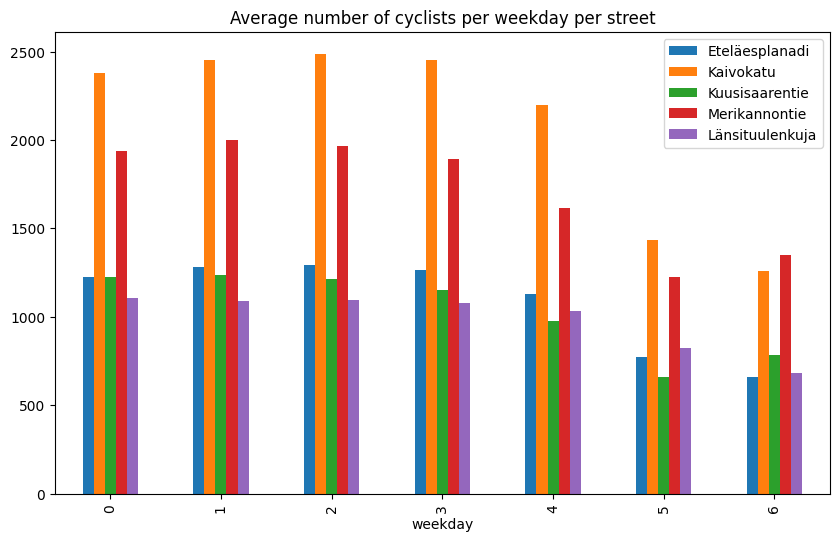

In [3]:
result = cyclists.groupby('weekday')
result = result.mean()
result = result.iloc[:, 0:5]

result.plot(kind='bar', stacked=False, title='Average number of cyclists per weekday per street', figsize=(10, 6))

<AxesSubplot: title={'center': 'Average number of cyclists per month per street'}, xlabel='month'>

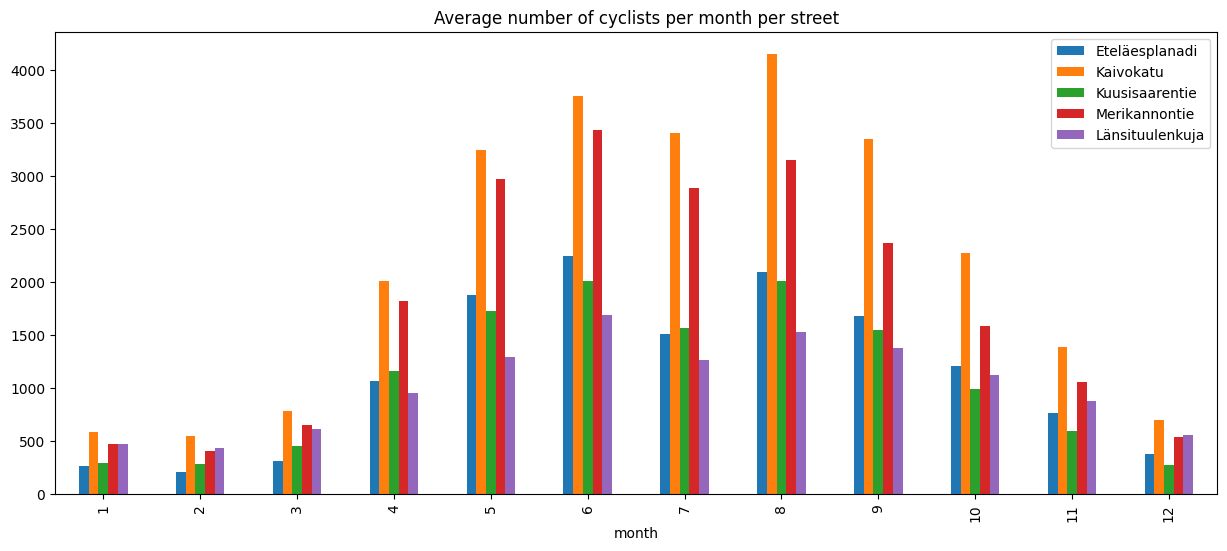

In [4]:
result = cyclists.groupby('month')
result = result.mean()
result = result.iloc[:, 0:5]

result.plot(kind='bar', stacked=False, title='Average number of cyclists per month per street', figsize=(15, 6))

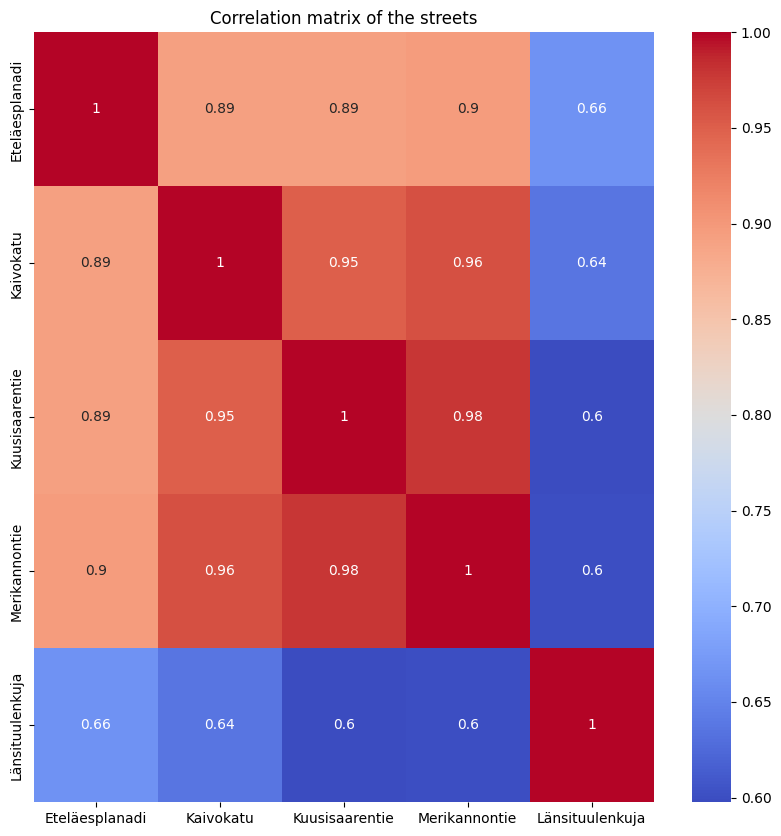

In [5]:
street_subset = cyclists.drop(columns=['weekday', 'month', 'day', 'year'])
result = street_subset.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(result, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of the streets')
plt.show()

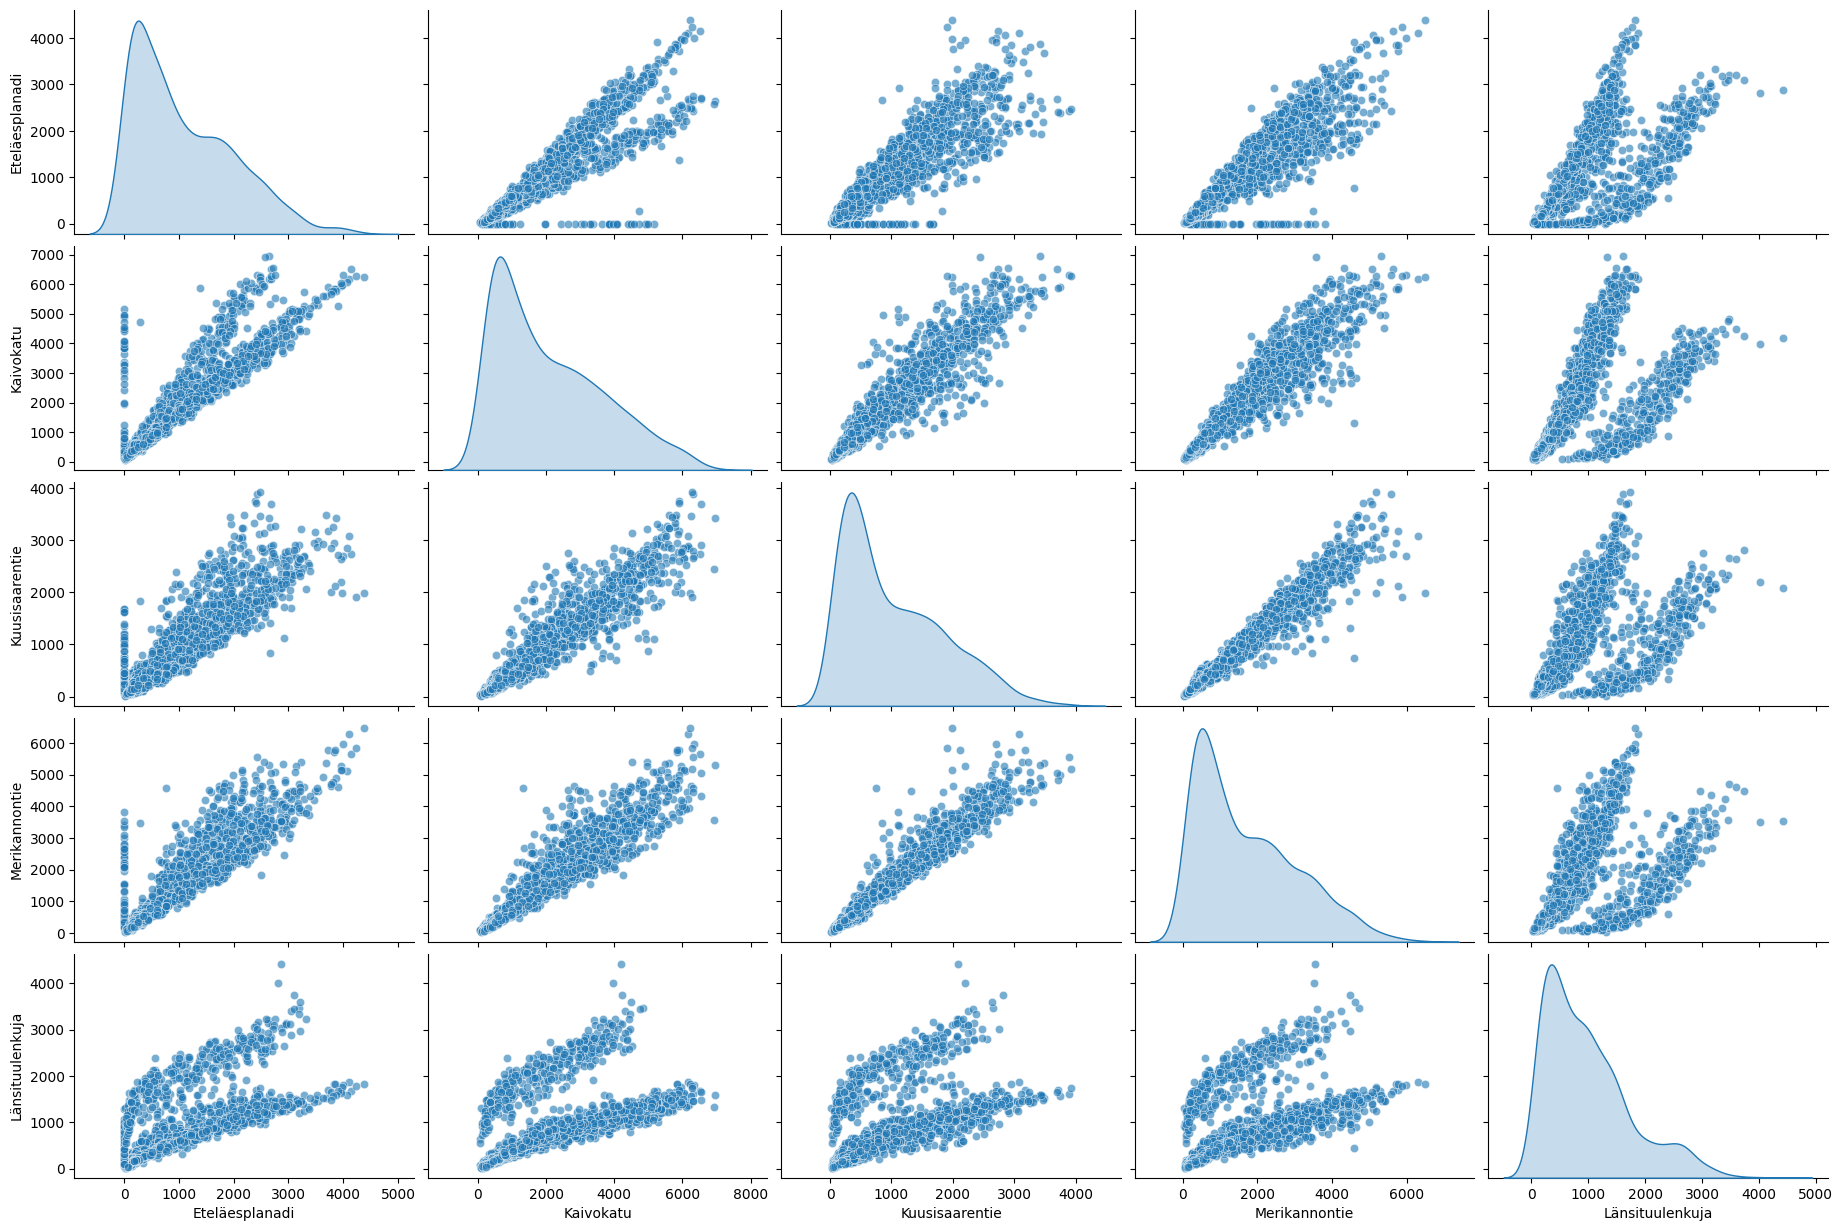

In [6]:
# print the scatter plots
sns.pairplot(street_subset, diag_kind='kde', height=2.5, aspect=1.5, plot_kws={'alpha': 0.6})
plt.show()

### Running

In [7]:
running = pd.read_csv('data/running.csv')
running.head()

,before,after
0,135.41,134.26
1,131.60,133.68
2,130.09,119.98
3,107.33,107.78
4,140.98,139.50


In [8]:
print(f"Mean before: {running['before'].mean()}, mean after: {running['after'].mean()}")
print(f"Std before {running['before'].std()}, std after: {running['after'].std()}")

print(f"Mean change due to training: {running['before'].mean() - running['after'].mean()}") 

# Confidence interval
d = DescrStatsW(running['before'] - running['after'])
d.tconfint_mean()

Mean before: 129.04160000000002, mean after: 124.9114
Std before 10.366792423062071, std after: 11.360442828750386
Mean change due to training: 4.130200000000016


(-0.03024119436114514, 8.290641194361147)

### Electric bikes

In [9]:
bikes_data = pd.read_csv('data/bikes.data')

bikes_data.head()

,ticket,cost,month,location_from,location_to,duration,distance,assistance,energy_used,energy_collected
0,single,0.35,9,MICROTEKNIA,PUIJONLAAKSO,411.0,2150,1,19.0,2.7
1,single,1.20,5,SATAMA,KEILANKANTA,1411.0,7130,1,53.8,15.3
2,savonia,0.00,9,TASAVALLANKATU,NEULAMÄKI,1308.0,5420,1,43.0,9.9
3,savonia,0.00,10,TORI,KAUPPAKATU,1036.0,1180,1,6.5,2.1
4,single,0.30,9,TORI,TORI,319.0,1120,1,13.7,1.2


In [23]:
def find_similar_distance_cost(row, df):
    valid_rows = df[[df["cost"] > 0 and df["ticket"] == row["ticket"]]]
    most_similar_row = valid_rows.iloc[(valid_rows["distance"] - row["distance"]).abs().idxmin()]

    return most_similar_row["cost"]

negative_cost = bikes_data[bikes_data.cost < 0]

if negative_cost.shape[0] > 0:
    print('There are negative values in cost column')
    bikes_data.loc[negative_cost.index, 'cost'] = negative_cost.apply(lambda row: find_similar_distance_cost(row, bikes_data), axis=1)
    print(bikes_data.head())

In [11]:
error_data = bikes_data[~bikes_data.month.isin(range(1, 13))]

if error_data.shape[0] > 0:
    print('There are values in month column that are not in range 1-12')

    bikes_data = bikes_data[bikes_data.month.isin(range(1, 13))]
    print(bikes_data.head())

In [24]:
def find_similar_distance_duration(row, df):
    valid_rows = df[[df["duration"] > 0 and df["ticket"] == row["ticket"]]]
    most_similar_row = valid_rows.iloc[(valid_rows["distance"] - row["distance"]).abs().idxmin()]

    return most_similar_row["duration"]

negative_duration = bikes_data[bikes_data.duration < 0]

if negative_duration.shape[0] > 0:
    print('There are negative values in duration column')
    bikes_data.loc[negative_duration.index, 'duration'] = negative_duration.apply(lambda row: find_similar_distance_duration(row, bikes_data), axis=1)

In [13]:
assistance_errors = bikes_data[~bikes_data.assistance.isin([0, 1])]

if assistance_errors.shape[0] > 0:
    print('There are values in assistance column that are not 0 or 1')

    bikes_data = bikes_data[bikes_data.assistance.isin([0, 1])]
    print(bikes_data.head())

In [14]:
print(bikes_data['ticket'].unique())    
print("Total number of rows: ", bikes_data.shape[0])

['single' 'savonia' 'season']
Total number of rows:  1774


(1774, 10)
Ticket savonia - distance: 498620, duration: 192624.0, cost: 202.0, number of rides: 254
Ticket season - distance: 1307300, duration: 325963.0, cost: 3.0, number of rides: 553
Ticket single - distance: 2558240, duration: 672341.0, cost: 666.45, number of rides: 967


array([<AxesSubplot: title={'center': 'distance'}, xlabel='ticket'>,
       <AxesSubplot: title={'center': 'duration'}, xlabel='ticket'>,
       <AxesSubplot: title={'center': 'cost'}, xlabel='ticket'>,
       <AxesSubplot: title={'center': 'ticket'}, xlabel='ticket'>],
      dtype=object)

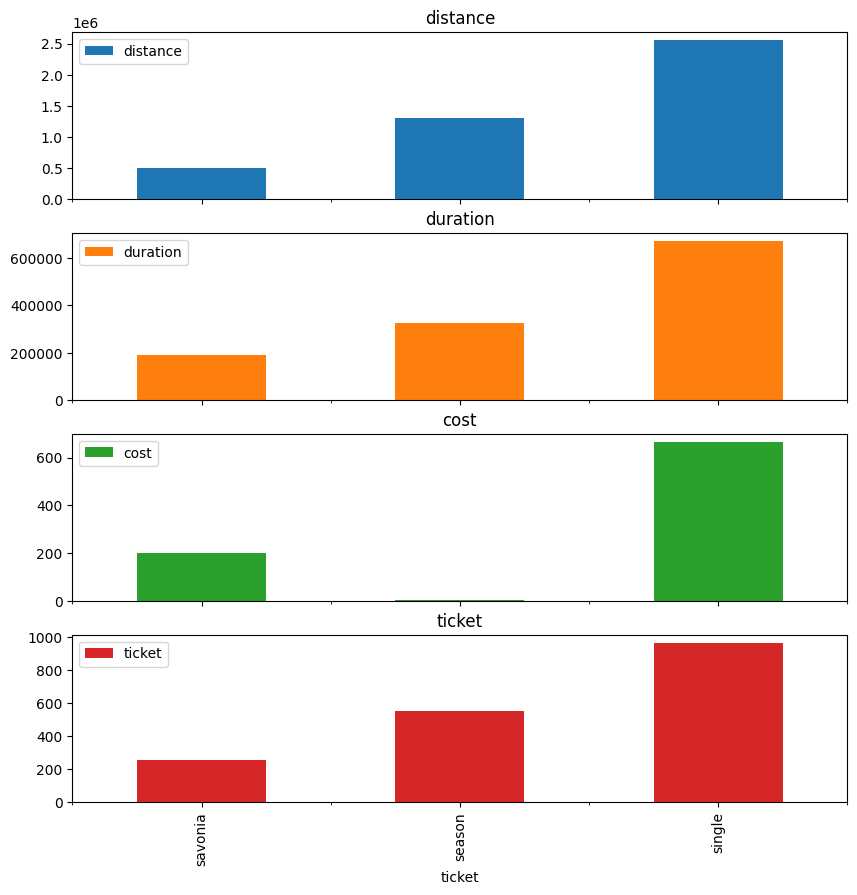

In [15]:
print(bikes_data.shape)
data = bikes_data.groupby('ticket').agg({'distance': 'sum', 'duration': 'sum', 'cost': 'sum', 'ticket': 'count'})

for ticket in data.index:
    print(f"Ticket {ticket} - distance: {data.loc[ticket, 'distance']}, duration: {data.loc[ticket, 'duration']}, cost: {data.loc[ticket, 'cost']}, number of rides: {data.loc[ticket, 'ticket']}")

# plotting results 
data.plot(kind='bar', subplots=True, figsize=(10, 10))

Ticket savonia - month 9 - distance: 244500
Ticket savonia - month 10 - distance: 254120
Ticket season - month 4 - distance: 30680
Ticket season - month 5 - distance: 258110
Ticket season - month 6 - distance: 244780
Ticket season - month 7 - distance: 268150
Ticket season - month 8 - distance: 210710
Ticket season - month 9 - distance: 184840
Ticket season - month 10 - distance: 110030
Ticket single - month 4 - distance: 32410
Ticket single - month 5 - distance: 493150
Ticket single - month 6 - distance: 710240
Ticket single - month 7 - distance: 594890
Ticket single - month 8 - distance: 353220
Ticket single - month 9 - distance: 240370
Ticket single - month 10 - distance: 133960


<AxesSubplot: xlabel='month'>

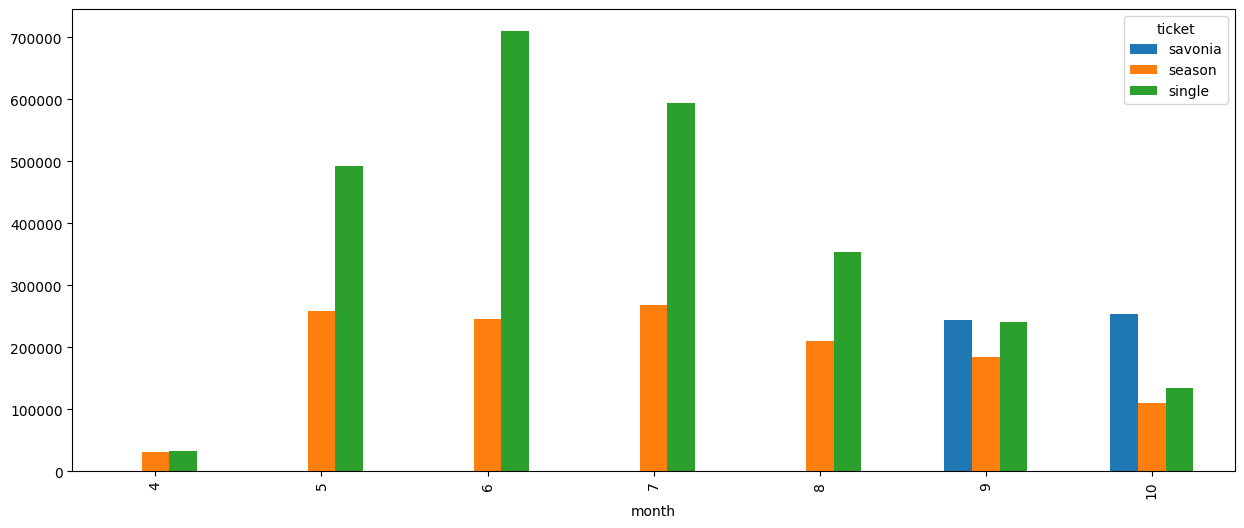

In [16]:
data = bikes_data.groupby(['ticket', 'month']).agg({'distance': 'sum'})

for ticket, month in data.index:
    print(f"Ticket {ticket} - month {month} - distance: {data.loc[(ticket, month), 'distance']}")

data = data.unstack(level=0)
data.columns = data.columns.droplevel()

data.plot(kind='bar', stacked=False, figsize=(15, 6))

count    1774.000000
mean      -11.760203
std        14.949025
min      -111.200000
25%       -19.900000
50%        -8.700000
75%         0.000000
max        20.700000
Name: net_energy_gain, dtype: float64


<AxesSubplot: ylabel='Frequency'>

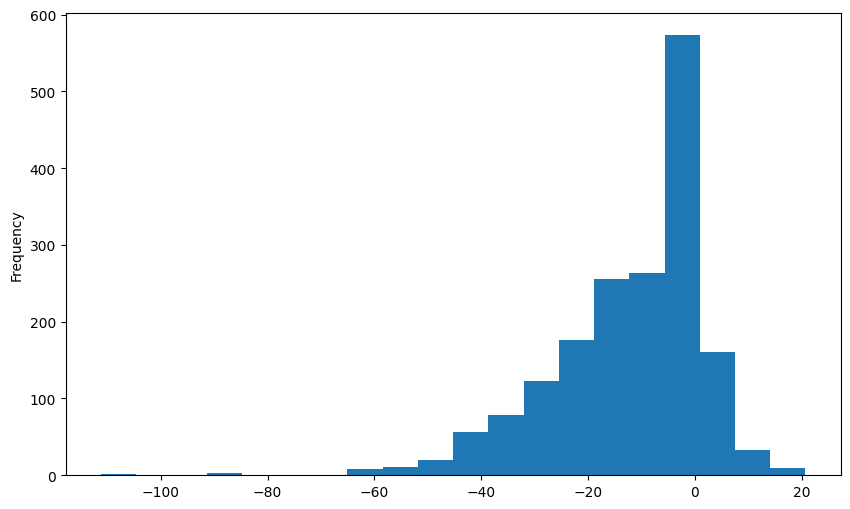

In [22]:
bikes_data["net_energy_gain"] = bikes_data["energy_collected"] - bikes_data["energy_used"]

print(bikes_data["net_energy_gain"].describe())
bikes_data["net_energy_gain"].plot(kind='hist', bins=20, figsize=(10, 6))